In [1]:
%matplotlib inline

## Load the MNIST digit dataset

In [1]:
#import pylab as plt
from sklearn.datasets import fetch_openml

# Download the MNIST dataset
X, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)

# normalize the sample into [0, 1]
X *= 1. / 255

## Testing BCM model on MNIST dataset

In [3]:
from plasticity.model import BCM
from plasticity.model.optimizer import Adam, SGD

model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation='relu', 
            optimizer=Adam(lr=4e-2), interaction_strength=-0.25, verbose=False)
model.fit(X)

BCM(batch_size=1000, interaction_strength=-0.25, mu=0.0, verbose=False, seed=42, num_epochs=10, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.04, lr_min=0.0), sigma=1.0, epochs_for_convergency=10, outputs=100, convergency_atol=0.01, activation=Relu(), precision=1e-30)

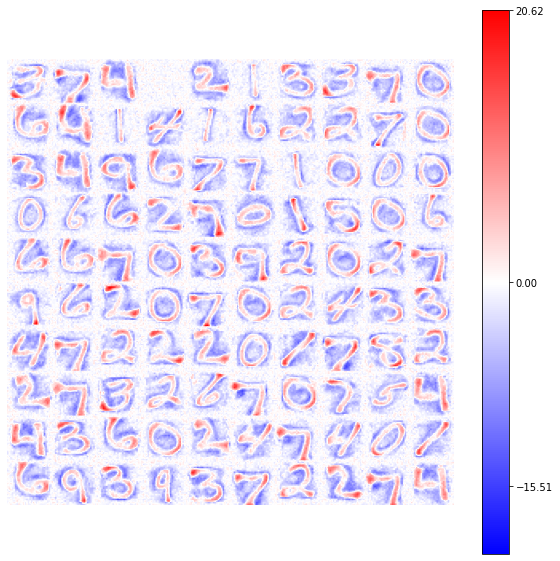

In [4]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))

## BCM inpainting

In [5]:
import numpy as np
import pylab as plt

idx = 1
reference_data = X[idx].reshape(28, 28)
half_input = reference_data.copy()
# nullify the lower section of the image
half_input[14:, :] = 0.

# prediction with linear activation function
prediction = np.einsum('ij, kj -> ik', model.weights, half_input.reshape(1, -1), optimize=True).T
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)].reshape(28, 28)

inpaint = half_input.copy()
# use the neuron connections to complete the image
inpaint[14:, :] = best_neuron[14:, :]

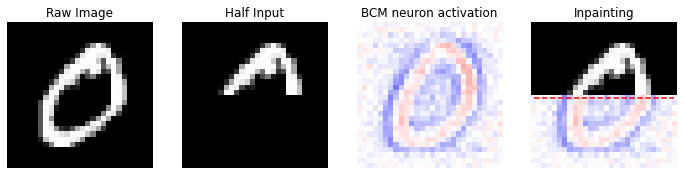

In [6]:
nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data, cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('BCM neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

## BCM classifier

In [7]:
from sklearn.preprocessing import OneHotEncoder

y_categorical = y.astype('int').reshape(-1, 1)
y_categorical = OneHotEncoder(sparse=False).fit_transform(y_categorical)

model = BCM(outputs=200, num_epochs=10, optimizer=Adam(learning_rate=4e-2), interaction_strength=-0.45,
            activation='Relu', batch_size=1000, verbose=False)
model.fit(X, y=y_categorical)

BCM(batch_size=1000, interaction_strength=-0.45, mu=0.0, verbose=False, seed=42, num_epochs=10, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), sigma=1.0, epochs_for_convergency=10, outputs=200, convergency_atol=0.01, activation=Relu(), precision=1e-30)

In [8]:
idx = 50
reference_data = X[idx].reshape(28, 28)
# set the corresponding labels to null
reference_data[28*28 :] = 0

prediction = model.predict(X[idx].reshape(1, -1), y=y_categorical[idx].reshape(1, -1))
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)
# extract the predicted label for each neuron as argmax of the label-connections
labels = model.weights[:, 28*28:].argmax(axis=1)

best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)

In [9]:
from collections import Counter

# extract the top 10 labels as the top-ranking connections
top_10 = sorted(zip(prediction.ravel(), labels), key=lambda x : x[0], reverse=True)[:10]
top_10 = [x[1] for x in top_10]
counter_labels = Counter(top_10)

Top 10 labels: [(3, 4), (8, 2), (2, 1), (1, 1), (5, 1), (0, 1)]


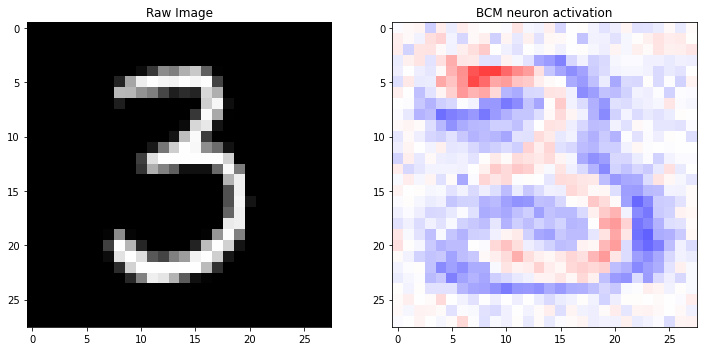

In [10]:
nc = np.amax(np.abs(model.weights))

print('Top 10 labels: {}'.format(counter_labels.most_common()))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(X[idx].reshape(28, 28), cmap='gray')
ax2.set_title('BCM neuron activation')
im = ax2.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc)

## BCM classifier performances

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=1/6, random_state=42)

model = BCM(outputs=1000, num_epochs=20, optimizer=Adam(learning_rate=4e-2), interaction_strength=-0.005,
            activation='Relu', batch_size=4000, verbose=False)
model.fit(x_train, y_train)

BCM(batch_size=4000, interaction_strength=-0.005, mu=0.0, verbose=False, seed=42, num_epochs=20, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), sigma=1.0, epochs_for_convergency=20, outputs=1000, convergency_atol=0.01, activation=Relu(), precision=1e-30)

In [12]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X=x_test, y=y_test)
predictions = [model.weights[np.argmax(x)][28*28:].argmax() for x in predictions]

y_true = y_test.argmax(axis=1)
y_pred = np.asarray(predictions)

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, y_pred)))

Accuracy score on test set: 0.815


In [13]:
# Prediction using the Top 10 ranking agreement
predictions = model.predict(X=x_test, y=y_test)
labels = model.weights[:, 28*28:].argmax(axis=1)

top_10 = []
for x in predictions:
    # order the predictions
    top = sorted(zip(x, labels), key=lambda x : x[0], reverse=True)[:10]
    top = [x[1] for x in top]
    # select the label as the most common prediction of the ranking
    counter_labels = Counter(top).most_common()
    top_10.append(counter_labels[0][0])

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, top_10)))

Accuracy score on test set: 0.864


## Testing Hopfield model on MNIST dataset

In [14]:
from plasticity.model import Hopfield

model = Hopfield(outputs=100, num_epochs=10, verbose=False)
model.fit(X)

Hopfield(batch_size=100, mu=0.0, verbose=False, seed=42, k=2, num_epochs=10, p=2.0, optimizer=SGD(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), sigma=1.0, epochs_for_convergency=10, outputs=100, convergency_atol=0.01, delta=0.4, precision=1e-30)

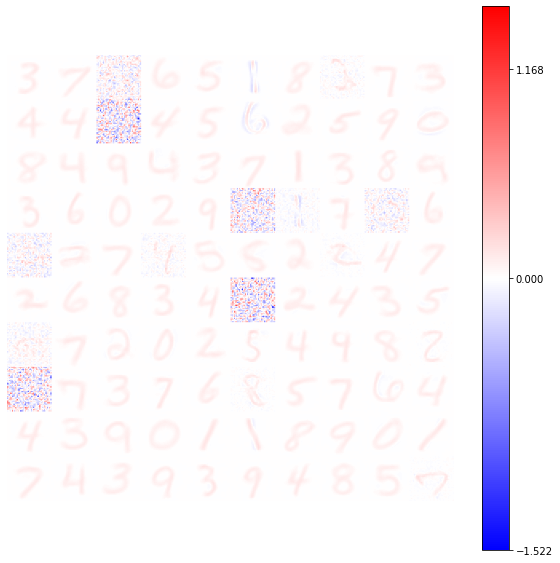

In [15]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))

## Hopfield inpainting

In [16]:
import numpy as np
import pylab as plt

idx = 1
reference_data = X[idx].reshape(28, 28)
half_input = reference_data.copy()
# nullify the lower section of the image
half_input[14:, :] = 0.

# prediction with linear activation function
prediction = np.einsum('ij, kj -> ik', model.weights, half_input.reshape(1, -1), optimize=True).T
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)].reshape(28, 28)

inpaint = half_input.copy()
# use the neuron connections to complete the image
inpaint[14:, :] = best_neuron[14:, :]

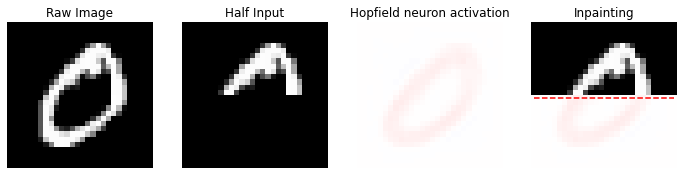

In [17]:
nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data, cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('Hopfield neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

## Hopfield classifier

In [18]:
from sklearn.preprocessing import OneHotEncoder

y_categorical = y.astype('int').reshape(-1, 1)
y_categorical = OneHotEncoder(sparse=False).fit_transform(y_categorical)

model = Hopfield(outputs=200, num_epochs=10, optimizer=Adam(learning_rate=4e-2),
                 batch_size=1000, verbose=False)
model.fit(X, y=y_categorical)

Hopfield(batch_size=1000, mu=0.0, verbose=False, seed=42, k=2, num_epochs=10, p=2.0, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), sigma=1.0, epochs_for_convergency=10, outputs=200, convergency_atol=0.01, delta=0.4, precision=1e-30)

In [19]:
idx = 50
reference_data = X[idx].reshape(28, 28)
# set the corresponding labels to null
reference_data[28*28 :] = 0

prediction = model.predict(X[idx].reshape(1, -1), y=y_categorical[idx].reshape(1, -1))
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)
# extract the predicted label for each neuron as argmax of the label-connections
labels = model.weights[:, 28*28:].argmax(axis=1)

best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)

In [20]:
from collections import Counter

# extract the top 10 labels as the top-ranking connections
top_10 = sorted(zip(prediction.ravel(), labels), key=lambda x : x[0], reverse=True)[:10]
top_10 = [x[1] for x in top_10]
counter_labels = Counter(top_10)

Top 10 labels: [(3, 9), (5, 1)]


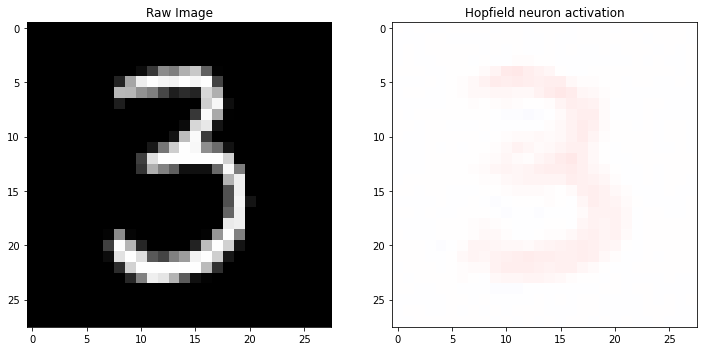

In [21]:
nc = np.amax(np.abs(model.weights))

print('Top 10 labels: {}'.format(counter_labels.most_common()))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(X[idx].reshape(28, 28), cmap='gray')
ax2.set_title('Hopfield neuron activation')
im = ax2.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc)

## Hopfield classifier performances

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=1/6, random_state=42)

model = Hopfield(outputs=1000, num_epochs=20, optimizer=Adam(learning_rate=4e-2),
                 batch_size=4000, verbose=False)
model.fit(x_train, y_train)

Hopfield(batch_size=4000, mu=0.0, verbose=False, seed=42, k=2, num_epochs=20, p=2.0, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), sigma=1.0, epochs_for_convergency=20, outputs=1000, convergency_atol=0.01, delta=0.4, precision=1e-30)

In [24]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X=x_test, y=y_test)
predictions = [model.weights[np.argmax(x)][28*28:].argmax() for x in predictions]

y_true = y_test.argmax(axis=1)
y_pred = np.asarray(predictions)

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, y_pred)))

Accuracy score on test set: 0.848


In [25]:
# Prediction using the Top 10 ranking agreement
predictions = model.predict(X=x_test, y=y_test)
labels = model.weights[:, 28*28:].argmax(axis=1)

top_10 = []
for x in predictions:
    # order the predictions
    top = sorted(zip(x, labels), key=lambda x : x[0], reverse=True)[:10]
    top = [x[1] for x in top]
    # select the label as the most common prediction of the ranking
    counter_labels = Counter(top).most_common()
    top_10.append(counter_labels[0][0])

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, top_10)))

Accuracy score on test set: 0.901
